In [1]:
using HDF5, StatsBase, PyPlot
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools, OrdenaSets

┌ Info: Precompiling OrdenaSets [top-level]
└ @ Base loading.jl:1273


In [2]:
arxname="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

In [3]:
arx=h5open(arxname)

HDF5 data file: /home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5

In [5]:
canales=read(arx["CanalesBuenos"])
lfp=read(arx["LFPSaturados"]);
nmax=size(lfp)[3]

2000

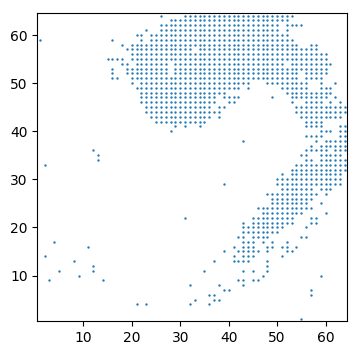

PyObject <matplotlib.collections.PathCollection object at 0x7fdad3484eb8>

In [7]:
ff=figure(figsize=(4,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(canales[:,2], canales[:,1], s=0.5)

In [8]:
yxref=[39,40]
orderchans=barreconjuntoyordena(canales, yxref);

alfamin = 0.015623728620476831


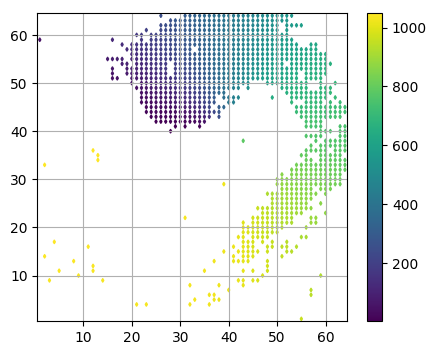

In [9]:
ff=figure(figsize=(5,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
#scatter(canales[:,2], canales[:,1], s=0.5)
scatter(orderchans[:,2], orderchans[:,1], marker="d",s=3, cmap="viridis", c=orderchans[:,3])
colorbar()
grid()

In [10]:
function freediaconis(datos)
    # Freedman and Diaconis
    n=length(datos)
    m=iqr(datos)
    result=2*m/cbrt(n)
    return result
end
    
function sacaentropia(datos::Array)
    binsize=freediaconis(datos)
    (vmin,vmax)=extrema(datos)
    normalizador=size(datos,1)
    if(binsize != 0 )
        rango=vmin:binsize:vmax
        histodo=fit(Histogram,datos,rango)
        pdf=histodo.weights./normalizador
        result=entropy(pdf)
    else
        result=0
    end
    return result
end

sacaentropia (generic function with 1 method)

In [11]:
function sacaentropia(datosX::Array, datosY::Array)
    # ambos arrays deben ser igual de largos ???
    binsizeX=freediaconis(datosX)
    binsizeY=freediaconis(datosY)
    if (binsizeX==0 || binsizeY==0)
        error(" ¡Esto que, no tiene variacion en los datos!")
    else
        (viX,vfX)=extrema(datosX)
        (viY,vfY)=extrema(datosY)
        rangoX=viX:binsizeX:vfX
        rangoY=viY:binsizeY:vfY
        
        histodo=fit(Histogram, (datosX, datosY), (rangoX, rangoY))
        
        pdf=histodo.weights
        pdf=pdf./sum(pdf)
        result=entropy(pdf)
        return result
        #return (result, histodo)
    end

end

sacaentropia (generic function with 2 methods)

In [12]:
function infomutua(datosX::Array, datosY::Array)
    hetaX=sacaentropia(datosX)
    hetaY=sacaentropia(datosY)
    hetaXY=sacaentropia(datosX,datosY)
    result=hetaX+hetaY-hetaXY
    return result
end

infomutua (generic function with 1 method)

In [38]:
nchan=size(orderchans, 1)
hetas=zeros(nchan)
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    hetas[j]=sacaentropia(ejemplo)
end

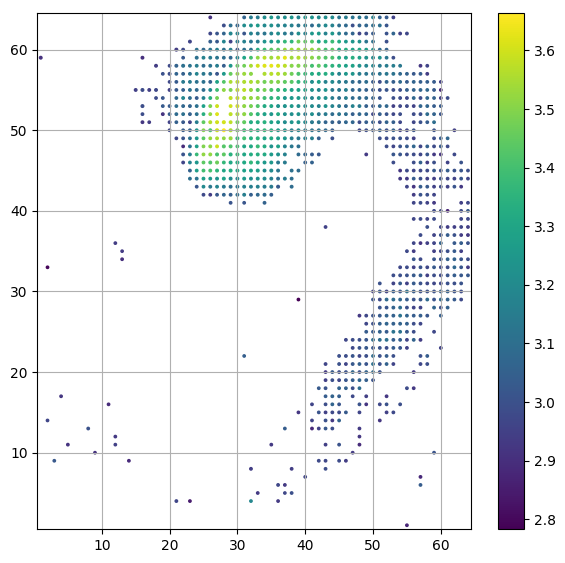

In [39]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[2:end,2], orderchans[2:end,1], s=hetas, c=hetas[2:end])
colorbar()
grid()

In [40]:
orderchans[141,:]

3-element Array{Int64,1}:
  50
  28
 141

In [41]:
findmax(hetas)

(3.6631774261451557, 141)

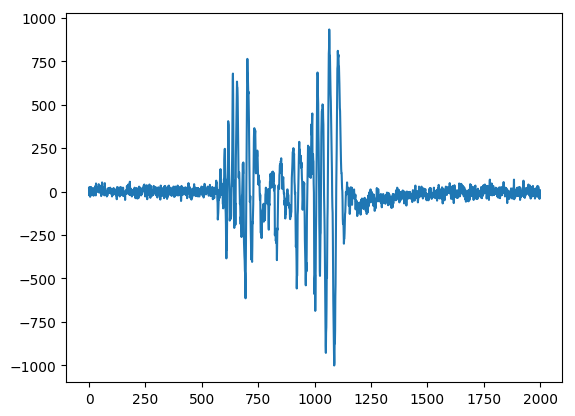

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdab6c301d0>

In [42]:
plot(lfp[50,28,:])

In [43]:
imutres=zeros(nchan)
refe=[50,28]
fijo=lfp[refe[1], refe[2],:]
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    imutres[j]=infomutua(fijo, ejemplo)
end

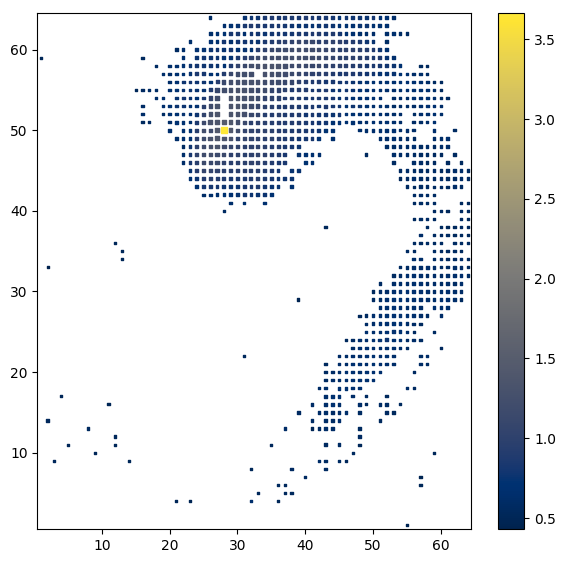

PyObject <matplotlib.colorbar.Colorbar object at 0x7fdab6f73048>

In [44]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=imutres.*5, c=imutres, cmap="cividis", marker="s")
colorbar()
#grid()

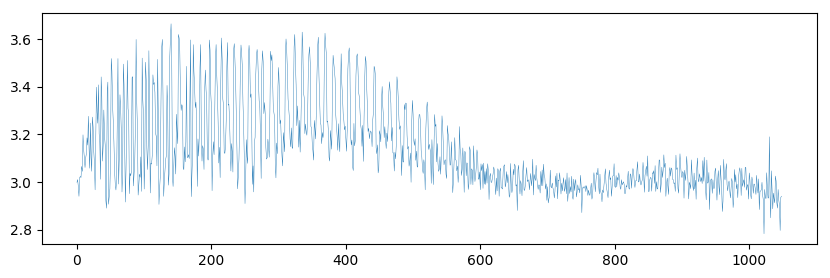

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdab6eb3d68>

In [46]:
figure(figsize=(10,3))
plot(hetas, lw=0.3)

In [57]:
porheta=sortperm(hetas, rev=true)
porim=sortperm(imutres, rev=true)

1049-element Array{Int64,1}:
  141
  153
  128
  154
  174
  108
  140
  152
  208
  216
  185
  121
  198
    ⋮
 1045
 1046
 1039
 1035
 1042
 1043
 1016
 1033
  961
  942
 1023
 1047

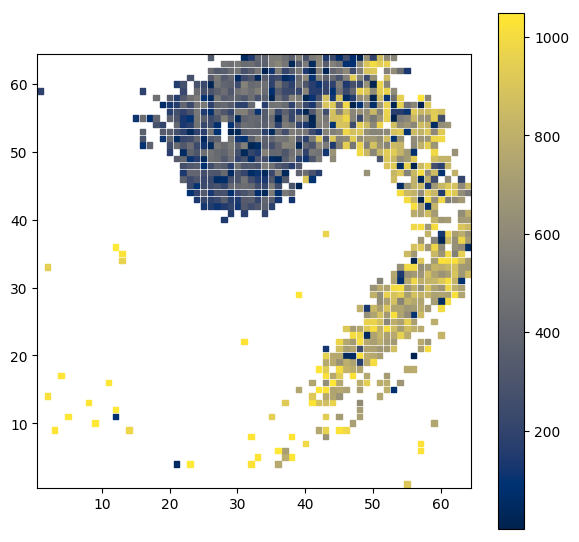

PyObject <matplotlib.colorbar.Colorbar object at 0x7fdab693b0f0>

In [58]:
ff=figure(figsize=(7,6.7))
axis("equal")
gca().set_aspect("equal", adjustable="box")
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=15, c=porim, cmap="cividis", marker="s")
colorbar()
#grid()

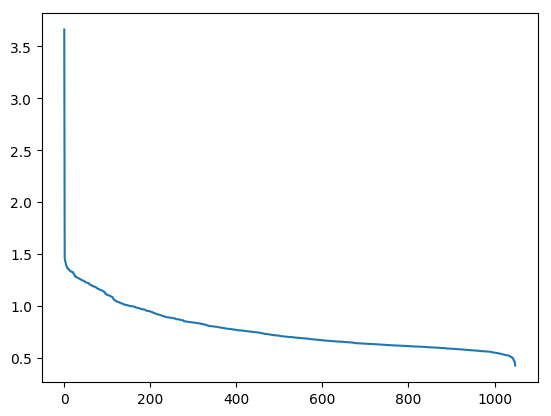

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdab716cd68>

In [59]:
plot(imutres[porim])

In [61]:
mutinfo=zeros(nchan,nchan);

for j=1:nchan
    for k=j+1:nchan
        
        reng1,col1=(orderchans[j,1], orderchans[j,2])
        reng2,col2=(orderchans[k,1], orderchans[k,2])
        
        dat1=lfp[reng1, col1,:]
        dat2=lfp[reng2, col2,:]
        
        mutinfo[j,k]=infomutua(dat1,dat2)
        end
end

In [67]:
for j=1:nchan
    mutinfo[j,j]=0
end

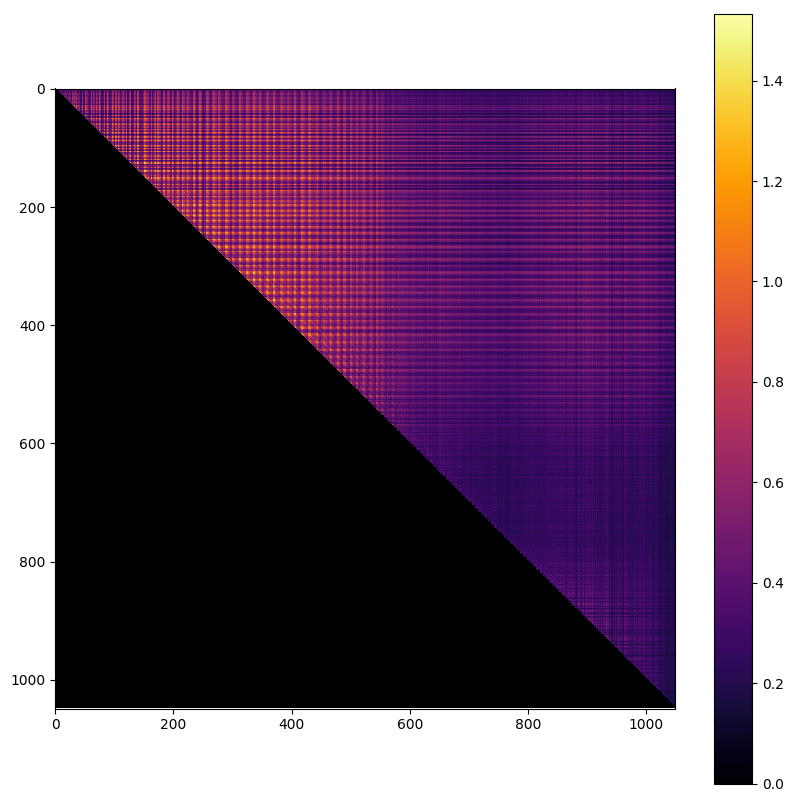

PyObject <matplotlib.colorbar.Colorbar object at 0x7fdab666e0b8>

In [69]:
figure(figsize=(10,10))
imshow(mutinfo, cmap="inferno")
colorbar()